In [1]:
import arviz as az
import pymc as pm
# import arviz.labels as azl

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import matplotlib as mpl
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pathlib import Path

## Reestimate model because of pickle problems

In [2]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_gp(y, X, l_prior, eta_prior, sigma_prior, kernel_type='M52', bayes_kws=dict(draws=1000, tune=1000, chains=2, cores=1), prop_Xu=None):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use. If None, use full marginal likelihood. If not none, use FTIC. 
    bayes_kw : kws for pm.sample
    X, y are dataframes. We'll use the column names. 
    """
    kernel_type = kernel_type.lower()
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values.flatten()
        X_cols = list(X.columns)

        
        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        covs = []
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='rbf':
                covs.append(pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='exponential':
                covs.append(pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='m52':
                covs.append(pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='m32':
                covs.append(pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
            if kernel_type=='m12':
                covs.append(pm.gp.cov.Matern12(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i]))
        # Covariance model
        cov_tot = np.sum(covs)*cov
        
        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Model
        if not (prop_Xu is None):
            # Inducing variables
            num_Xu = int(X_a.shape[0]*prop_Xu)
            Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)
            gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, Xu=Xu, noise=sigma_n)
        else:
            gp = pm.gp.Marginal(cov_func=cov_tot)
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)
            
        
        if not (bayes_kws is None):
            trace = pm.sample(**bayes_kws)
            result = trace
        else:
            start_val = 1
            x0 = dict(zip(['l_'+X_cols[i] for i in range(len(X_cols))], [start_val]*len(X_cols)))
            x0.update({ 'eta': 1, 'sigma_n': 1})

            options={'disp': None, 'maxcor': 10, 
                     'ftol': 2.220446049250313e-12, 'gtol': 1e-12, 
                     'eps': 1e-12, 'maxfun': 15000, 'maxiter': 15000, 
                     'iprint': - 1, 'maxls': 20, 
                     'finite_diff_rel_step': None}
            mp = pm.find_MAP(start = x0, options=options)
            result = mp
    
    return gp, result, model

def bootstrap(n_samples,y, X, seed=42, **kwargs):
    rng = np.random.default_rng(seed)
    all_params = []
    all_preds = []
    i = 0
    j = 0
    while (i < n_samples) and (j < 250):
        print(' ', i, end=', ')
        ix = np.array(y.index)
        bs_ix = rng.choice(ix, size=len(ix), replace=True)
        new_y, new_X = y.loc[bs_ix, :], X.loc[bs_ix, :]
        try: 
            gp, mp, model = fit_gp(new_y, new_X, **kwargs)
            all_params.append(mp)
            with model:
                y_pred, var = gp.predict(new_X.values, point=mp, diag=True)
                all_preds.append((new_y, y_pred, var))
            i += 1
            
        except Exception as e: 
            print('error', e)
        print(j, end=', ')

        j += 1
        
    print()

    return all_params, all_preds
        

In [3]:
root_path = '../1fme/sensitivity/ts'
experiments = [
    ['dihedrals', None, 'exponential', 'ts' ], 
    ['distances', 'linear', 'exponential', 'ts' ], 
    ['distances', 'logistic', 'exponential', 'ts'], 
    ['distances', 'logistic', 'exponential', 'ei']]


In [4]:
l_prior = gamma(1, 0.5)
eta_prior = hcauchy(1)
sigma_prior = hcauchy(1)


In [5]:
# models = []

# params = []
# preds = []
# n_boot = 100

# for i, (feat, trans, kernel, dv) in enumerate(experiments):
#     print(feat, trans, kernel)
#     kwargs = dict(l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
#                   kernel_type=kernel,  # Kernel
#                   prop_Xu=None,  # proportion of data points which are inducing variables.
#                   bayes_kws=None)    
    
#     if dv == 'vamp2_eq':
#         results_path = Path(root_path).resolve().joinpath(f"{feat}_{trans}_{kernel}_mml.pkl")

#         results = pickle.load(results_path.open('rb'))
#         data_s = results['data']
#         y, X = data_s.iloc[:, [0]], data_s.iloc[:, 1:]
#     elif dv == 'ei': 
#         results_path = Path(root_path).resolve().joinpath(f"{feat}_{trans}_{kernel}_with_ei.pkl")
#         results = pickle.load(results_path.open('rb'))
#         data_s = results['data_s']
#         y, X = data_s.iloc[:, [0]], data_s.iloc[:, 1:]    
#     elif dv == 'ts':
#         results_path = Path(root_path).resolve().joinpath(f"{feat}_{trans}_{kernel}.pkl")

#         results = pickle.load(results_path.open('rb'))
#         data_s = results['data_s']
#         y, X = data_s.iloc[:, [0]], data_s.iloc[:, 1:]    
        
#     param, pred = bootstrap(n_boot, y, X, **kwargs)
#     params.append(param)
#     preds.append(pred)

Collate results

In [6]:
# param_df = []
# keep_params = ['l_dim', 'l_lag', 'l_states', 'feature', 'l_cent', 'l_steep']
# dv_label_dict = dict(ts = r"$\log{t_{2}}$", ei = r"$\log{\mathbb{E}[I]}$")
                     
# for i, experiment in enumerate(experiments): 
#     bs_params = params[i]
#     lab = experiment[0]
#     if experiment[1] is not None: 
#         lab += f"-{experiment[1]}"
#     lab +=  f"\n(y={dv_label_dict[experiment[-1]]})"
    
#     df = pd.concat([pd.DataFrame(x, index=[j]) for j, x in enumerate(bs_params)])
#     df['feature'] = lab    
#     param_df.append(df)
    
# param_df = pd.concat(param_df)
# param_df = param_df.loc[:, keep_params]
# param_df_m = param_df.melt(id_vars=['feature'], var_name='hyperparameter')
# param_df_m['R'] = 1.0/param_df_m['value']

# var_name_map={"l_states": r"Num. states", 
#             "l_dim": r"Num. dims", 
#             "l_lag": r"$\tau_{tICA}$", 
#             "l_cent": r"Centre", 
#              "l_steep": r"Steepness"}

# param_df_m['hyperparameter'] = param_df_m['hyperparameter'].apply(lambda x: var_name_map[x])

In [7]:
# param_df_m.to_hdf(Path(root_path).parent.joinpath('sensitivity_bootstrap.h5'), 
#                  key='sensitivity_bootstrap')

param_df_m = pd.read_hdf(Path(root_path).parent.joinpath('sensitivity_bootstrap.h5'), 
                 key='sensitivity_bootstrap')

## Sensitivity plot

In [8]:
short_names = {'dihedrals': 'dihed.', 'distances-logistic': 'logit(dist.)', 'distances-linear': 
              'dist.'}

def f(x):
    for short, long in short_names.items(): 
        x = x.replace(short, long)
    return x

param_df_m['feature'] = param_df_m['feature'].apply(f)

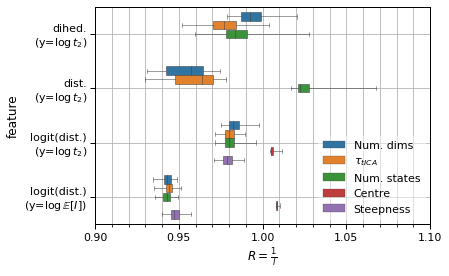

In [9]:
with sns.plotting_context('paper', font_scale=1.25): 
    fig, ax = plt.subplots(1)

    sns.boxplot(y='feature', x='R', hue='hyperparameter', data=param_df_m,ax=ax, 
               whis=(0, 100), orient='h', linewidth=0.5)
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, l,  loc='lower right', 
              framealpha=0.5, frameon=True, edgecolor='w')
    
    
    ax.set_xlim(0.9, 1.1)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
    ax.grid(which='both')
    ax.set_axisbelow(True)
    ax.set_xlabel(r'$R = \frac{1}{l}$')
    # ax.set_xscale('log')
    plt.savefig(Path(root_path).parent.joinpath('sensitivity.pdf'), bbox_inches='tight')
    

## Pair plot

In [10]:
(feat, trans, kernel, dv)  = experiments[3]
print(feat, trans, kernel)
kwargs = dict(l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
              kernel_type=kernel,  # Kernel
              prop_Xu=None,  # proportion of data points which are inducing variables.
              bayes_kws=None)    

if dv == 'vamp2_eq':
    results_path = Path(root_path).resolve().joinpath(f"{feat}_{trans}_{kernel}_mml.pkl")

    results = pickle.load(results_path.open('rb'))
    data_s = results['data']
    y, X = data_s.iloc[:, [0]], data_s.iloc[:, 1:]
elif dv == 'ei': 
    results_path = Path(root_path).resolve().joinpath(f"{feat}_{trans}_{kernel}_with_ei.pkl")
    results = pickle.load(results_path.open('rb'))
    data_s = results['data_s']
    y, X = data_s.iloc[:, [0]], data_s.iloc[:, 1:]    
elif dv == 'ts':
    results_path = Path(root_path).resolve().joinpath(f"{feat}_{trans}_{kernel}.pkl")

    results = pickle.load(results_path.open('rb'))
    data_s = results['data_s']
    y, X = data_s.iloc[:, [0]], data_s.iloc[:, 1:]    

gp, mp, model = fit_gp(y, X, **kwargs)


distances logistic exponential


We're going to plot steepness and centre variables as a contour map. Then we keep all other variables at the values which maximize the *observed* surface. 

In [26]:
pred_ei, pred_var = gp.predict(Xnew=X.values, point=mp, model=model, diag=True, pred_noise=True)
max_ix = np.argmax(pred_ei)
hold_vals = X.values[max_ix, :]

# plot_ys = np.quantile(pred_ei, q=(0.25, 0.5, 0.75), method='closest_observation')
# cont_idxs = [(pred_ei == x).flatten() for x in plot_ys]
# cont_Xs = [X.values[ix,:] for ix  in cont_idxs]

In [17]:
# Scaling parameters from CALC_optimisation

if dv == 'ei': 
    iqr, median = 8.807052668480674, -9.996184378841864
    min_s, max_s = -4.801855202786361, 1.106684867374743
elif dv == 'ts': 
    min_s, max_s = -2.5680505392801685, 3.965207192114922
    median, iqr = 7.608876608833085, 0.6489738308067583    
    
    


def unscale_x(x, ix):
    hp_path = '../../experiments/hpsample.h5'
    hps = pd.read_hdf(hp_path)
    hps.reset_index(inplace=True)

    data = hps.loc[:, ['distances__scheme', 'tica__dim', 'tica__lag', 'cluster__k', 
                'distances__steepness', 'distances__centre']]
    # print(data.columns[ix])
    data['distances__scheme'] = data['distances__scheme'].apply(lambda x: 1*(x == 'closest-heavy'))
    data = data.values

    xmin, xmax = data.min(axis=0), data.max(axis=0)
    xmin, xmax = xmin[ix], xmax[ix]
    
    x_unscaled = (x - min_s)*(xmax - xmin)/(max_s - min_s) + xmin
    if ix == 0: 
        x_unscaled = x
        
    return x_unscaled

def unscale_y(y): 
    # xmin, xmax = min_s, max_s
    
    return y*iqr + median


In [118]:
var_name_map={"states": r"Num. states ($n$)", 
            "dim": r"Num. dims ($m$)", 
            "lag": r"TICA lag ($\tau_{T}$, ns)", 
            "cent": r"Centre ($c$, $\AA$)", 
             "steep": r"Steepness ($s$, $\AA$"+r"$^{-1}$)", 
             "scheme[T.closest-heavy]": "Scheme ($d$)"}
plot_y_labels = [r"$y_{q=0.25}$",r"$y_{q=0.5}$", r"$y_{q=0.75}$"]

gp_cols = sns.color_palette("icefire", 11)
gp_cols = [gp_cols[i] for i in [0, 5, 10]]
x_col = sns.color_palette('colorblind')[2]

In [119]:
plot_ij = [4, 5]
hold_ij = [0, 1, 2, 3]
n_points = 50

Xmin, Xmax = X.min(axis=0), X.max(axis=0)

xxs = [np.repeat(hold_vals[i], 1) for i in hold_ij]
xxs =  xxs + [np.linspace(Xmin[i], Xmax[i], n_points) for i in plot_ij]


xxs = np.meshgrid(*xxs, indexing='ij')
Xnew = np.concatenate([x.reshape(-1, 1) for x in xxs], axis=1)
ynew, _ = gp.predict(Xnew=Xnew, point=mp, model=model, diag=True, pred_noise=True)


Y = ynew.reshape(n_points, n_points)
Y = unscale_y(Y)
X1 = Xnew[..., plot_ij[0]].reshape(n_points, n_points) # Steepness
X1 = unscale_x(X1, plot_ij[0])
X2 = Xnew[..., plot_ij[1]].reshape(n_points, n_points) # Center
X2 = unscale_x(X2, plot_ij[1])


hold_label = ""
for ix in hold_ij:
    var_name = var_name_map[list(X.columns)[ix]]
    hold_label += f"{var_name}: "

    val = unscale_x(hold_vals[ix], ix)
    if 'Scheme' in var_name: 
        val = ['C$\alpha$-C$\alpha$', '$X-X$'][int(val)]
        hold_label += f"{val}\n"
    else:
        hold_label += f"{int(val):d}\n"
    


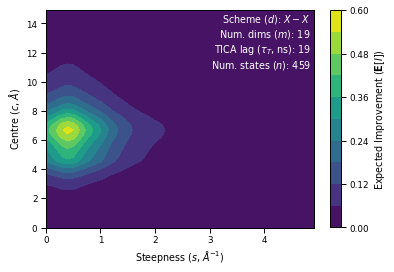

In [120]:
with sns.plotting_context('paper', font_scale=1):
    fig, axes = plt.subplots(1, figsize=(6, 4))
    ax = axes
    
    cbar = ax.contourf(X1/10, X2*10,  np.exp(Y), levels=10)
    ax.set_ylabel(var_name_map['cent'])
    ax.set_xlabel(var_name_map['steep'])
    fig.colorbar(cbar, label = r"Expected Improvement ($\mathbf{E}[I]$)")
    
    ax.annotate(text=hold_label, xy=(0.99, 0.99), xycoords='axes fraction', ha='right', va='top', 
                c='w')
    plt.savefig(Path(root_path).parent.joinpath(f'surface_{feat}_{trans}_{dv}.pdf'), bbox_inches='tight')


In [121]:

# with sns.plotting_context('paper', font_scale=1.25):
#     fig, axes = plt.subplots(2, 3, sharey=True, sharex=False, figsize=(6, 4))
#     xlabels = list(X.columns)
#     n_points = 10

#     for i, ax in enumerate(axes.flatten()): 
#         if i < X.shape[1]:
#             plot_X = X.values[:, i]
#             ax.annotate(text=f"({list('abcdefg')[i]})", xy=(0.03, 0.95), xycoords='axes fraction', 
#                         ha='left', va='top')
            
#             hp_col_num = i + 1*(feat == 'dihedrals')

#             for j in range(len(cont_Xs)): 
#                 xxs = [np.array(x[k]) for x in cont_Xs[j] for k in range(len(x))]
#                 xxs[i] = np.linspace(plot_X.min(), plot_X.max(), n_points)
#                 xxs = np.meshgrid(*xxs)
#                 xxs = [xx.reshape(-1, 1) for xx in xxs]
#                 plot_Xgrid = np.concatenate(xxs, axis=1)
#                 plot_y, plot_var = gp.predict(Xnew=plot_Xgrid, point=mp, model=model, diag=True, pred_noise=True)
                
                
#                 ax.plot(unscale_x(x=xxs[i],ix=hp_col_num), unscale_y(plot_y), color=gp_cols[j], label=plot_y_labels[j])

#             ax.scatter(unscale_x(plot_X, hp_col_num), unscale_y(pred_ei), marker='o', s=5, color=x_col)

#             ax.set_xlabel(var_name_map[xlabels[i]])
#             if (i == 0) & (feat != 'dihedrals'):
#                 ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0, 1]))
#                 ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([r'$\alpha$-C', 'C-H']))

#             if i == 2: 
#                 ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

#             if i in [0, 3]: 
#                 if dv == 'ei':
#                     ax.set_ylabel(r"$\log{\mathbf{E}[I]}$")
#                 elif dv == 'ts': 
#                     ax.set_ylabel(r"$\log{t_{2}}$")
#         else: 
#             ax.set_axis_off()
#     plt.tight_layout(pad=0.2)
#     # plt.savefig(Path(root_path).parent.joinpath(f'predictions_pair_plot_{feat}_{trans}_{dv}.pdf'), bbox_inches='tight')
